### Попытка понять, как делить отрезок \[0, 1\] на части

Предположим, что мы делим изоляционным деревом массив одномерных данных.
Если при этом мы хотим оценить плотность вероятности [?], то ветвление производим
по порогу, выбранному случайным образом от 0 до 1. Вне зависимости от реальных
значений семплов.

Этот подход расходится с тем, как делается в изоляционном лесе, где порог выбирается
случайным образом между минимуом m и максимумом M, т.е. на отрезке \[m, M\].

Вопрос -- как совместить эти два подхода? Чтобы и плотность вероятности
оценить можно было, и учесть распределение данных.

Идея -- сделаем ветвление чуть сложнее, чем в изоляционном лесе. Представим, что мы
ветвимся случайным образом, не глядя на данные, до тех пор, пока не попадём в сами
данные. Более строго -- ветвимся по отрезку \[0, 1\], пока не попадём в \[m, M\].

Понятно, что таким образом мы разделим отрезок либо на две, либо на три, либо на
четыре части. На две разделим, если попадём в \[m, M\] сразу. На три поделим, если сперва
будем ветвиться в одну сторону всё время, и только потом попадём в отрезок \[m, M\]. А на
четыре поделим, если сперва будем ветвиться в разные стороны, а в конце попадём в отрезок
\[m, M\].

Таким образом имеем разбиение отрезка \[0, 1\] на четыре фрагмента в общем случае.
Точки концов отрезков обозначим 0, l, m, t, M, L, 1. Здесь t -- итоговый порог, а точки
l и L -- это максимальный и минимальный пороги при правом и левом ветвлении, когда
случайное число попадает мимо отрезка \[m, M\]. Потенциально l и L могут быть равны
0 и 1, соответственно. В том случае, когда соответствующих ветвлений не происходит.

Получается, что порог t мы выбрали по точно таким же принципам, как это сделано
в изоляционном лесе, т.е. из равномерного распределения на носителе \[m, M\]. Но при этом
мы так же получили ещё два числа: l и L, которые задают границы. За этими границами
плотность распределения следует оценивать как 0. Что прямо соответствует статье [?].

После всего сказанно остаётся ответить на вопрос -- можно ли получить те же границы
l и L совместно с порогом t без лишних действий? Просто выбрав их из каких-то распределений.
Только распределения следует подобрать так, чтобы модель была статистически эквивалентной
рассмотренному здесь алгоритму.

Вот поиском этой модели мы и займёмся в этой тетради.

In [46]:
using Plots
using Statistics

In [137]:
function sample_ends(m::Float64, M::Float64; depth::Int=-1, short::Bool=false)
    t = rand(Float64)
    
    if short
        x = max(M - (M - m) / rand(Float64), 0)
        y = (x == 0) ? (M / rand(Float64)) : ((M - x) / sqrt(rand(Float64)) + x)
        return (M - m) * t + m, x, 0.0, min(y, 1), 0.0
    end
    
    if depth == 0
        return (M - m) * t + m, 0.0, 0.0, 1.0, 0.0
    end

    if t < m
        x, y, yn, z, zn = sample_ends((m - t) / (1 - t), (M - t) / (1 - t); depth=depth-1)
        x * (1 - t) + t, y * (1 - t) + t, yn + 1.0, z * (1 - t) + t, zn
    elseif t > M
        x, y, yn, z, zn = sample_ends(m / t, M / t; depth=depth-1)
        x * t, y * t, yn, z * t, zn + 1.0
    else
        t, 0.0, 0.0, 1.0, 0.0
    end
end


function sample_ends(m::Float64, M::Float64, n::Int64; depth::Int=-1, short::Bool=false)
    samples = Array{Float64}(undef, 5, n)
    for i in range(1, n)
        samples[:, i] .= sample_ends(m, M; depth=depth, short=short)
    end
    samples
end


function beta_estimate(x)
    x_mean = mean(x)
    x_var = var(x; corrected=false, mean=x_mean)
    nu = x_mean * (1 - x_mean) / x_var - 1
    (x_mean * nu, (1 - x_mean) * nu)
end

beta_estimate (generic function with 1 method)

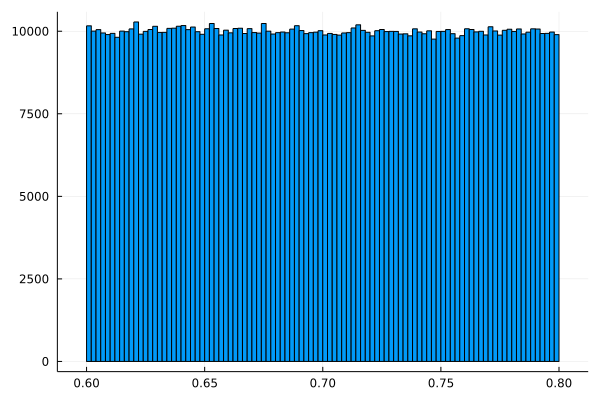

In [71]:
# Проверяем, что на [m, M] распределение действительно получилось равномерным

samples = sample_ends(0.6, 0.8, 1000000)
histogram(samples[1, :], label=nothing)

0.600447

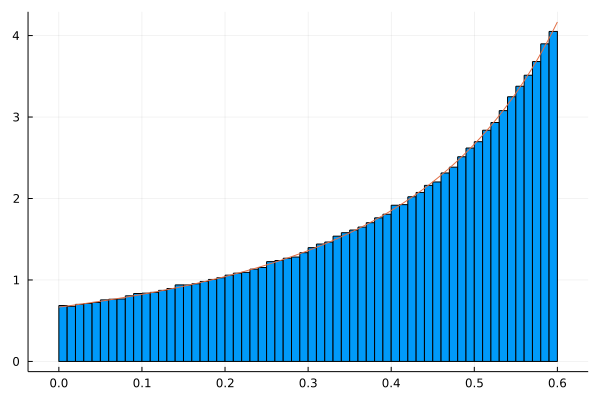

In [49]:
# Вероятность распределиться и плотность распределения

samples = sample_ends(0.6, 1.0, 1000000)

lefts = filter(p -> p != 0, samples[2, :])
display(size(lefts, 1) / size(samples, 2))

p = histogram(lefts, label=nothing, normalize=true)
begin
    t = range(0, 0.6, 100)
    plot!(p, t, @.(0.4 / 0.6 / (1 - t)^2), label=nothing)
end

0.399869

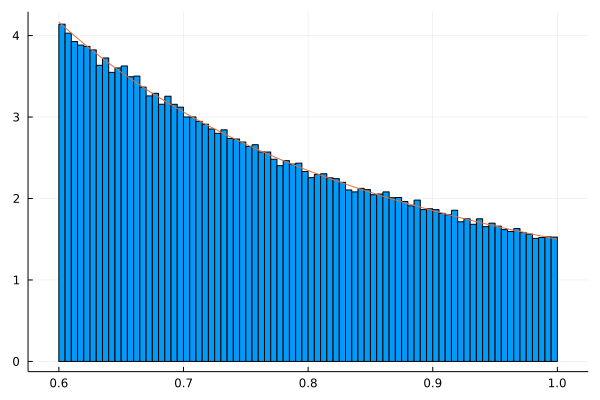

In [50]:
# Вероятность распределиться и плотность распределения

samples = sample_ends(0.0, 0.6, 1000000)

rights = filter(p -> p != 1, samples[4, :])
display(size(rights, 1) / size(samples, 2))

p = histogram(rights, label=nothing, normalize=true)
begin
    t = range(0.6, 1.0, 100)
    plot!(p, t, @.(0.6 / 0.4 / t^2), label=nothing)
end

0.749968

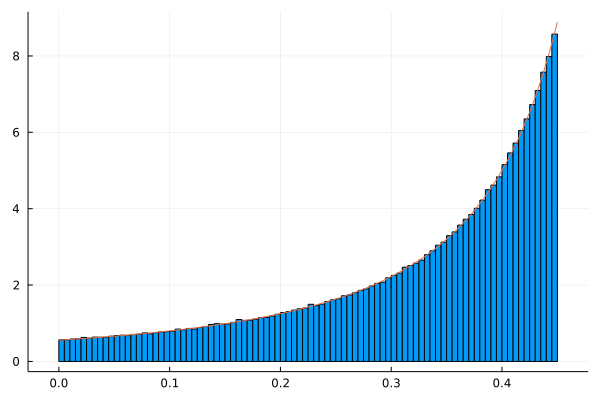

In [160]:
# Вероятность распределиться и плотность распределения

xi = 0.55
eta = 0.6
samples = sample_ends(1 - xi, eta, 1000000, short=true)

lefts = samples[:, samples[2, :] .!= 0][2, :]
display(size(lefts, 1) / size(samples, 2))

p = histogram(lefts, label=nothing, normalize=true)
begin
    t = range(0, 1 - xi, 100)
    k = 1 / (xi + eta - 1) - 1 / eta
    plot!(p, t, @.(1 / (eta - t)^2 / k) , label=nothing)
end

0.750288

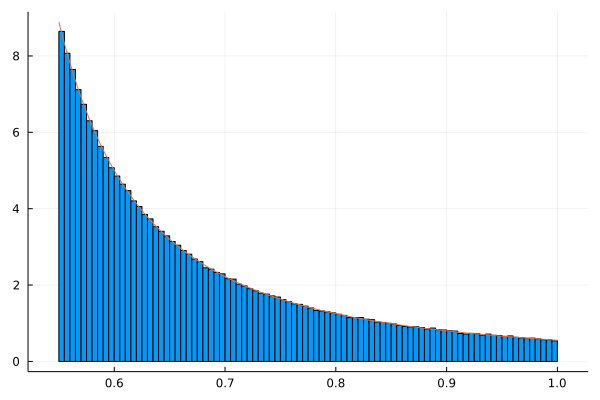

In [161]:
# Вероятность распределиться и плотность распределения

xi = 0.6
eta = 0.55
samples = sample_ends(1 - xi, eta, 1000000, short=true)

rights = samples[:, samples[4, :] .!= 1][4, :]
display(size(rights, 1) / size(samples, 2))

p = histogram(rights, label=nothing, normalize=true)
begin
    t = range(eta, 1, 100)
    k = 1 / (xi + eta - 1) - 1 / xi
    plot!(p, t, @.(1 / (xi - 1 + t)^2 / k) , label=nothing)
end

In [111]:
using HypothesisTests

In [163]:
ApproximateTwoSampleKSTest(lefts, 1 .- rights)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00160562

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.2883

Details:
    number of observations:   [749968,750288]
    KS-statistic:              0.9833205820539153


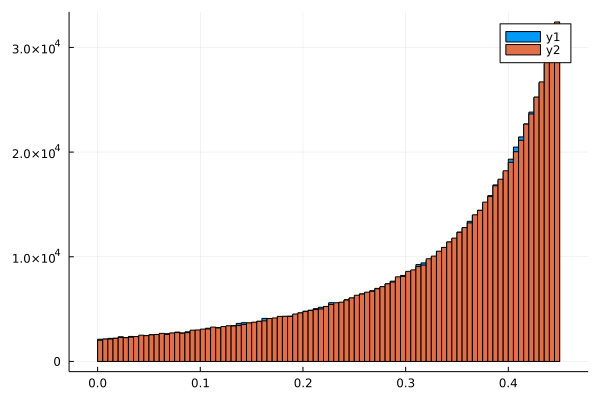

In [164]:
p = histogram(lefts)
histogram!(p, 1 .- rights)